In [1]:
import numpy as np
import sympy as sp
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit, minimize

<a href="http://airfoiltools.com/airfoil/naca4digit?MNaca4DigitForm%5Bcamber%5D=2&MNaca4DigitForm%5Bposition%5D=40&MNaca4DigitForm%5Bthick%5D=12&MNaca4DigitForm%5BnumPoints%5D=81&MNaca4DigitForm%5BcosSpace%5D=0&MNaca4DigitForm%5BcosSpace%5D=1&MNaca4DigitForm%5BcloseTe%5D=0&yt0=Plot"> NACA 4 digit airfoil</a>

In [2]:
airfoil_data = np.loadtxt("NACA_2412_AIRFOIL.txt", skiprows=1)

In [3]:
airfoil_data.shape

(81, 2)

In [4]:
airfoil_data[:10]

array([[1.000084, 0.001257],
       [0.998557, 0.001575],
       [0.993984, 0.002524],
       [0.986392, 0.004086],
       [0.975825, 0.006231],
       [0.962343, 0.008922],
       [0.946027, 0.01211 ],
       [0.926971, 0.01574 ],
       [0.905287, 0.019752],
       [0.881104, 0.024079]])

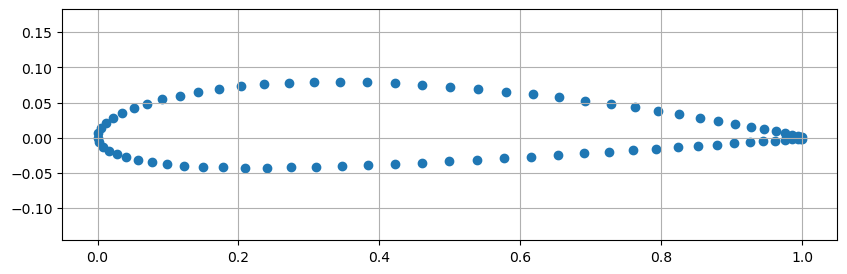

In [72]:
fig, ax = plt.subplots(figsize=(10,3))

ax.scatter(airfoil_data[:,0], airfoil_data[:,1])
ax.grid(True)
ax.axis('equal');

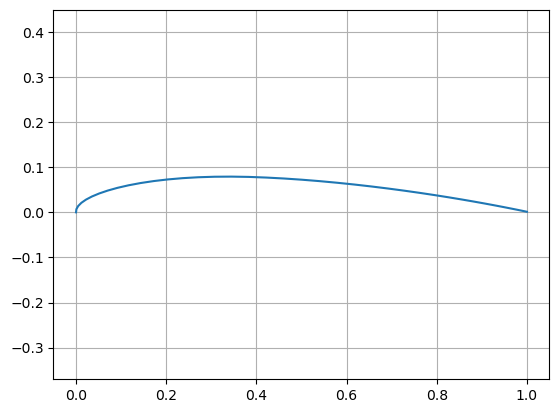

In [67]:
# Координаты верхней части профиля из загруженных данных
upper_surface_x = airfoil_data[:41, 0]
upper_surface_y = airfoil_data[:41, 1]

plt.plot(upper_surface_x, upper_surface_y)
plt.axis('equal')
plt.grid(True)

Профиль описывается с помощью так называемой линии прогиба (camber) и толщины (thickness).

Прогиб при $0 \leq x \leq p$ описывается зависимостью
$$
y_c = \frac{M}{p^2}\left(2 p x - x^2\right),
$$
а при $ p < x \leq 1$ описывается зависимостью
$$
y_c = \frac{M}{(1-p)^2}
\left(
1 - 2 p + 2 p x -x^2
\right)
$$
где $x=p$ 	&ndash; точка экстремума; $M$ &ndash; коэффициент масштаба.

Распределение толщины описывается зависимостью
$$
y_t = \frac{T}{0,2}(a_0 x^{0,5} + a_1 x + a_2 x^2 + a_3 x^3 + a_4 x^4),
$$
$$
a_0 = 0,2969,\quad 
a_1 = -0,126,\quad
a_2 = -0,3516,\quad
a_3 = 0,2843,\quad
a_4 = -0,1015,
$$
где $T$ &ndash; коэффициент масштаба.

Будем искать координаты верхней линия профиля в виде (отличается от официальной версии)
$$
(x, y_c(x)+y_t(x)),\quad
0 \leq x \leq 1,
$$
а нижней в виде 
$$
(x, y_c(x)-y_t(x)),\quad
0 \leq x \leq 1.
$$

Определим коэффициенты $p$, $M$, $T$, $a_0$, $a_1$, $a_2$, $a_3$, $a_4$ для наших данных.

In [1045]:
def foil_thickness(x, a0, a1, a2, a3, a4, T): # половина толщины нашего профиля
    return T / 0.2 * (
            a0 * x**0.5 +
            a1 * x +
            a2 * x**2 + 
            a3 * x**3 + 
            a4 * x**4)

def foil_camber(x, p, M): # прогиб (camber)
    left_x = x <= p
    right_x = x > p

    res = np.empty_like(x)
    res[left_x] = M/p**2*(2*p*x[left_x] - x[left_x]**2)
    res[right_x] = M/(1-p)**2*(1-2*p+2*p*x[right_x]-x[right_x]**2)              

    return res

In [1046]:
# Аналитическое выражение для координт верхней поверхности профиля
upper_profile = lambda x, p, M, a0, a1, a2, a3, a4, T: \
    foil_camber(x, p, M)  + foil_thickness(x, a0, a1, a2, a3, a4, T)

# Аналитическое выражение для координт нижней поверхности профиля
lower_profile = lambda x, p, M, a0, a1, a2, a3, a4, T: \
    foil_camber(x, p, M)  - foil_thickness(x, a0, a1, a2, a3, a4, T)

# upper_profile = lambda x, p, M,  T: foil_camber(x, p, M)  + foil_thickness(x, 0.2969, -0.126, -0.3516, 0.2843, -0.1015, T)

# Координаты верхней части профиля из загруженных данных
upper_surface_x = airfoil_data[:41, 0]
upper_surface_y = airfoil_data[:41, 1]

# Координаты нижней части профиля из загруженных данных
lower_surface_x = airfoil_data[41:, 0]
lower_surface_y = airfoil_data[41:, 1]

# Минимизируемый функционал для нахождения параметров профиля
func = lambda params: \
    np.sum((upper_profile(upper_surface_x, *params) - upper_surface_y)**2) + \
    np.sum((lower_profile(lower_surface_x, *params) - lower_surface_y)**2)
    
res = minimize(func, (0.1, 0.1, 1, 1, 1, 1, 1, 1))
opt_profile_params = res.x
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 2.8600346005428055e-05
        x: [ 3.910e-01  2.018e-02  2.635e+01 -1.742e+01 -1.061e+01
            -1.795e-01  2.082e+00  1.446e-03]
      nit: 83
      jac: [ 4.219e-07  2.956e-06 -3.340e-07 -6.744e-07  3.853e-07
            -3.546e-07 -7.740e-08  4.513e-06]
 hess_inv: [[ 3.798e+01  1.978e-02 ... -2.283e+00 -2.381e-04]
            [ 1.978e-02  1.662e-02 ...  2.235e-01  8.101e-06]
            ...
            [-2.283e+00  2.235e-01 ...  1.047e+04 -2.702e-02]
            [-2.381e-04  8.101e-06 ... -2.702e-02  4.188e-05]]
     nfev: 1044
     njev: 116

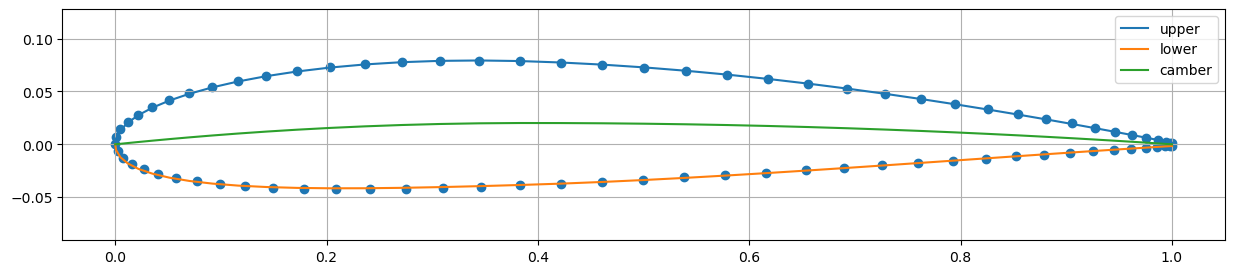

In [1047]:
fig, ax = plt.subplots(figsize=(15,3))

ax.plot(upper_surface_x, upper_profile(upper_surface_x, *res.x), label='upper')
ax.plot(upper_surface_x, lower_profile(upper_surface_x, *res.x), label='lower')
ax.plot(upper_surface_x, foil_camber(upper_surface_x, res.x[0], res.x[1]), label='camber')

ax.axis('equal')
ax.scatter(airfoil_data[:,0], airfoil_data[:,1])
ax.grid(True)
ax.legend(loc='best');


In [1048]:
def real_to_complex(x):
    return x[:,0] + 1j * x[:, 1]

def complex_to_real(z):
    return np.stack((np.real(z), np.imag(z)), axis=1)

In [1049]:
def transform(z, a, b):
    
    zp = np.concatenate(
        (
         np.ones(z.shape[0], dtype=complex).reshape(-1,1),
         np.repeat(z.reshape(-1, 1), a.shape[0]-1, axis=1)
        ),
        axis = 1
    )

    # zp = np.repeat(z.reshape(-1, 1), a.shape[0], axis=1)
    zn = np.repeat((1/z).reshape(-1, 1), b.shape[0], axis=1)
    
    return np.sum(a.reshape(1,-1)*np.cumprod(zp, axis=1), axis=1) + \
           np.sum(b.reshape(1,-1)*np.cumprod(zn, axis=1), axis=1)

np.abs(transform(np.array([1j, 4.]), np.array([1., 2.+1j, 2.], dtype=complex), np.array([1., 1.], dtype=complex)))

array([ 3.16227766, 41.50569426])

In [1050]:
complex_airfoil_data = real_to_complex(airfoil_data) 
complex_airfoil_data -= np.average(complex_airfoil_data)

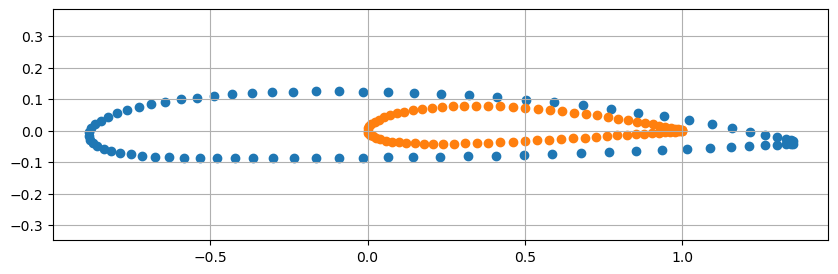

In [1051]:
N = 4
params = np.array([0, 0, 2, 0, 1, 0, 1, 0])

tr1_data = complex_to_real(transform(
    complex_airfoil_data, 
    real_to_complex(params[:2*N].reshape(-1,2)),
    real_to_complex(params[2*N:].reshape(-1,2))
))

fig, ax = plt.subplots(figsize=(10,3))

ax.scatter(tr1_data[:,0], tr1_data[:,1])
ax.scatter(airfoil_data[:,0], airfoil_data[:, 1])

ax.axis('equal')
ax.grid(True)

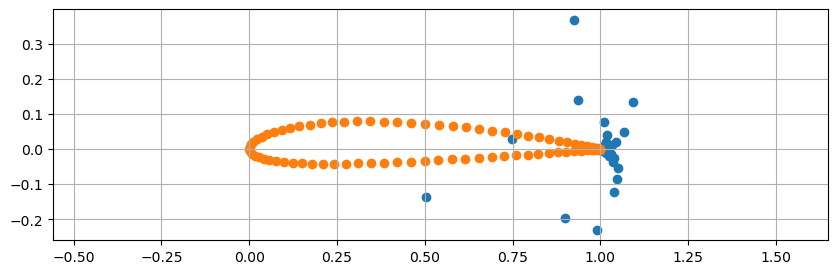

In [121]:
N = 2
params = np.array([1, 0, 0, 0, 
                   0.001, 0, 0.001, 0])

tr1_data = complex_to_real(transform(
    complex_airfoil_data, 
    real_to_complex(params[:2*N].reshape(-1,2)),
    real_to_complex(params[2*N:].reshape(-1,2))
))

fig, ax = plt.subplots(figsize=(10,3))

ax.scatter(tr1_data[:,0], tr1_data[:,1])
ax.scatter(airfoil_data[:,0], airfoil_data[:, 1])

ax.axis('equal')
ax.grid(True)

In [1311]:
N = 1 # positive degree params
M = 2 # total number of params

# func = lambda params: \
#     np.sum(
#         (np.abs(
#             transform(
#                 complex_airfoil_data, 
#                 real_to_complex(params[:2*N].reshape(-1,2)),
#                 real_to_complex(params[2*N:].reshape(-1,2))
#             )
#         ) - 1)**2/complex_airfoil_data.shape[0]
#     )

func = lambda params: \
    np.sum(
        (np.imag(
            transform(
                complex_airfoil_data, 
                real_to_complex(params[:2*N].reshape(-1,2)),
                real_to_complex(params[2*N:].reshape(-1,2))
            )
        ))**2/complex_airfoil_data.shape[0]
    )

# func(np.array([0, 0, 1, 0]))

x0 = np.ones((2*M,), dtype=float)
res = minimize(func, x0)
res

  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.9800480289116875e-15
        x: [ 1.000e+00 -3.779e-08 -6.656e-09 -9.032e-09]
      nit: 8
      jac: [ 0.000e+00 -6.386e-08  2.885e-08 -6.863e-08]
 hess_inv: [[ 1.000e+00  0.000e+00  0.000e+00  0.000e+00]
            [ 0.000e+00  5.009e-01 -1.856e-03 -3.184e-03]
            [ 0.000e+00 -1.856e-03  2.568e-02  2.488e-04]
            [ 0.000e+00 -3.184e-03  2.488e-04  2.567e-02]]
     nfev: 50
     njev: 10

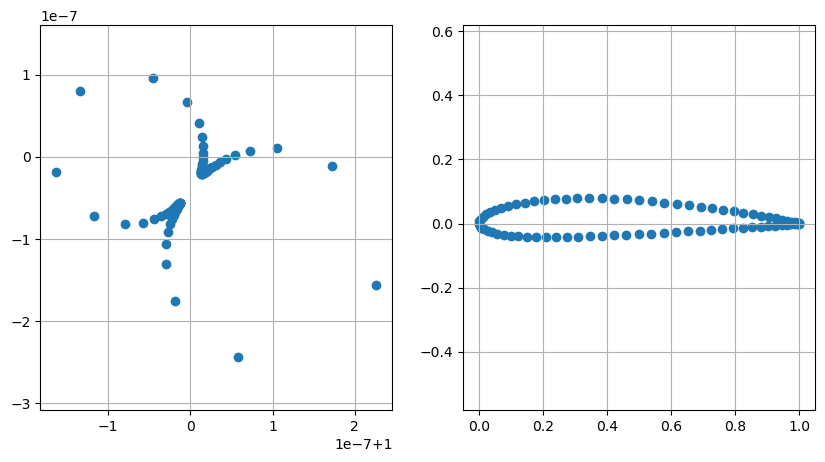

In [1312]:
transformed_airfoil_data = complex_to_real(
    transform(
        complex_airfoil_data, 
        real_to_complex(res.x[:2*N].reshape(-1,2)),
        real_to_complex(res.x[2*N:].reshape(-1,2))
    )
)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

circle = plt.Circle((0, 0), 1, color='r')
ax[0].axis('equal')
# ax[0].add_patch(circle)

ax[0].scatter(transformed_airfoil_data[:,0], transformed_airfoil_data[:, 1])
ax[1].scatter(airfoil_data[:,0], airfoil_data[:, 1])

for a in ax:
    a.grid(True)
    a.axis('equal')

In [52]:
res.x[:2]

array([ 0.41846551, -0.68667076])

In [1284]:
# Равномерная генерация точек внутри профиля по линии прогиба
def generate_coords(camber, num):
    x = np.linspace(0.1, 0.7, num = num)
    return x, camber(x)

class FoilComplexPotential:
    def __init__(self, 
                 camber, translation,
                 source_number = 1, vortex_number = 0, dipole_number = 0):
        self.source_number = source_number
        self.vortex_number = vortex_number
        self.dipole_number = dipole_number

        self._params = (np.random.sample((3*self.source_number + 3*self.vortex_number + 4*self.dipole_number))-0.5)/1000
        # self._params = np.((3*self.source_number + 3*self.vortex_number + 4*self.dipole_number))

        self.vortex_start_idx = 3*self.source_number
        self.dipole_start_idx = self.vortex_start_idx + 3*self.vortex_number
        
        x, y = generate_coords(camber, self.source_number)
        self._params[1:self.vortex_start_idx:3] = x + translation[0]
        self._params[2:self.vortex_start_idx:3] = y + translation[1]

        x, y = generate_coords(camber, self.vortex_number)
        self._params[self.vortex_start_idx+1:self.dipole_start_idx:3] = x + translation[0]
        self._params[self.vortex_start_idx+2:self.dipole_start_idx:3] = y + translation[1]

        x, y = generate_coords(camber, self.dipole_number)
        self._params[self.dipole_start_idx+2::4] = x + translation[0]
        self._params[self.dipole_start_idx+3::4] = y + translation[1]
    
    def w(self, z, params):

        source_params = params[:self.vortex_start_idx:3]/2./np.pi
        source_coords =      params[1:self.vortex_start_idx:3] + \
                        1j * params[2:self.vortex_start_idx:3]
        
        vortex_params = params[self.vortex_start_idx:self.dipole_start_idx:3]/2./np.pi/1j
        vortex_coords =      params[self.vortex_start_idx+1:self.dipole_start_idx:3] + \
                        1j * params[self.vortex_start_idx+2:self.dipole_start_idx:3]
        
        dipole_params = params[self.dipole_start_idx::4]*np.exp(1j*params[self.dipole_start_idx+1::4])/2./np.pi
        dipole_coords =      params[self.dipole_start_idx+2::4] + \
                        1j * params[self.dipole_start_idx+3::4]

        res  = np.sum(source_params[:, None]*np.log(z[None,:] - source_coords[:, None]), axis=0)
        res += np.sum(vortex_params[:, None]*np.log(z[None,:] - vortex_coords[:, None]), axis=0)
        res += np.sum(dipole_params[:, None]/(z[None, :] - dipole_coords[:, None]), axis=0)

        return res

    def velocity(self, z, params):

        source_params = params[:self.vortex_start_idx:3]/2./np.pi
        source_coords =      params[1:self.vortex_start_idx:3] + \
                        1j * params[2:self.vortex_start_idx:3]
        
        vortex_params = params[self.vortex_start_idx:self.dipole_start_idx:3]/2./np.pi/1j
        vortex_coords =      params[self.vortex_start_idx+1:self.dipole_start_idx:3] + \
                        1j * params[self.vortex_start_idx+2:self.dipole_start_idx:3]
        
        dipole_params = params[self.dipole_start_idx::4]*np.exp(1j*params[self.dipole_start_idx+1::4])/2./np.pi
        dipole_coords =      params[self.dipole_start_idx+2::4] + \
                        1j * params[self.dipole_start_idx+3::4]

        res  = np.sum(source_params[:, None, None]/(z - source_coords[:, None, None]), axis=0)
        res += np.sum(vortex_params[:, None, None]/(z - vortex_coords[:, None, None]), axis=0)
        res -= np.sum(dipole_params[:, None, None]/(z - dipole_coords[:, None, None])**2, axis=0)

        return np.conjugate(res)

    def fit_translation(self, vx, vy, z, method=None):

        v = vx - 1j*vy
        
        func = lambda params: \
            np.sum((np.imag(self.w(z, params) + v * z))**2)/z.shape[0]
        
        res = minimize(func, self._params, method=method, options={'disp':True})

        return res

    def get_coords(self, params):
        source_coords = (params[1:self.vortex_start_idx:3], params[2:self.vortex_start_idx:3])
        vortex_coords = (
            params[self.vortex_start_idx+1:self.dipole_start_idx:3],
            params[self.vortex_start_idx+2:self.dipole_start_idx:3]
        )
        dipole_coords = (
            params[self.dipole_start_idx+2::4],
            params[self.dipole_start_idx+3::4]
        )

        return source_coords, vortex_coords, dipole_coords
        
    def print_info(self, params):
        source_params = params[:self.vortex_start_idx:3]
        source_coords =      params[1:self.vortex_start_idx:3] + \
                        1j * params[2:self.vortex_start_idx:3]
        
        vortex_params = params[self.vortex_start_idx:self.dipole_start_idx:3]
        vortex_coords =      params[self.vortex_start_idx+1:self.dipole_start_idx:3] + \
                        1j * params[self.vortex_start_idx+2:self.dipole_start_idx:3]
        
        dipole_params = params[self.dipole_start_idx::4] + 1j*params[self.dipole_start_idx+1::4]/np.pi*180
        dipole_coords =      params[self.dipole_start_idx+2::4] + \
                        1j * params[self.dipole_start_idx+3::4] 
        
        print('Количество источников: ', self.source_number)
        print('Координаты источников: ', complex_to_real(source_coords))
        print('Обильности источников: ', source_params)
        print('Суммарная обильности источников: ', np.sum(source_params))
        print()

        print('Количество вихрей: ', self.vortex_number)
        print('Координаты вихрей: ', complex_to_real(vortex_coords))
        print('Обильности вихрей: ', vortex_params)
        print('Суммарная обильности вихрей: ', np.sum(vortex_params))
        print()
        
        print('Количество диполей: ', self.dipole_number)
        print('Координаты диполей: ', complex_to_real(dipole_coords))
        print('Обильности диполей: ', complex_to_real(dipole_params))



In [1285]:
alfa = np.linspace(0, 2*np.pi, num=100)
# circle_data = (1 - 0.5*np.cos(alfa)) * np.exp(1j*alfa)
circle_data = np.exp(1j*alfa)

circle_data.shape

(100,)

In [1286]:
vx = 1.
vy = 0

foil_potential = FoilComplexPotential(
    lambda x: 0, 
    (-0.5, 0),
    0, 0, 1
)

res = foil_potential.fit_translation(vx, vy, circle_data)
res

Optimization terminated successfully.
         Current function value: 0.000000
         Iterations: 9
         Function evaluations: 55
         Gradient evaluations: 11


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 3.1863753109166155e-11
        x: [ 6.283e+00 -5.923e-09  7.283e-06 -5.994e-09]
      nit: 9
      jac: [ 5.306e-07  1.423e-09  7.217e-06  1.353e-09]
 hess_inv: [[ 3.927e+01 -1.692e-05 -2.065e-01  3.468e-05]
            [-1.692e-05  1.000e+00 -2.063e-05 -2.655e-08]
            [-2.065e-01 -2.063e-05  9.376e-01 -2.318e-05]
            [ 3.468e-05 -2.655e-08 -2.318e-05  1.000e+00]]
     nfev: 55
     njev: 11

In [1287]:
foil_potential.print_info(res.x)

Количество источников:  0
Координаты источников:  []
Обильности источников:  []
Суммарная обильности источников:  0.0

Количество вихрей:  0
Координаты вихрей:  []
Обильности вихрей:  []
Суммарная обильности вихрей:  0.0

Количество диполей:  1
Координаты диполей:  [[ 7.28279273e-06 -5.99397176e-09]]
Обильности диполей:  [[ 6.28320646e+00 -3.39373797e-07]]


In [1288]:
w, h = 4, 3
Y, X = np.mgrid[-h:h:300j, -w:w:300j]
Z = X + 1j*Y
v = foil_potential.velocity(Z, res.x) + vx + 1j*vy
U = np.real(v)
V = np.imag(v)

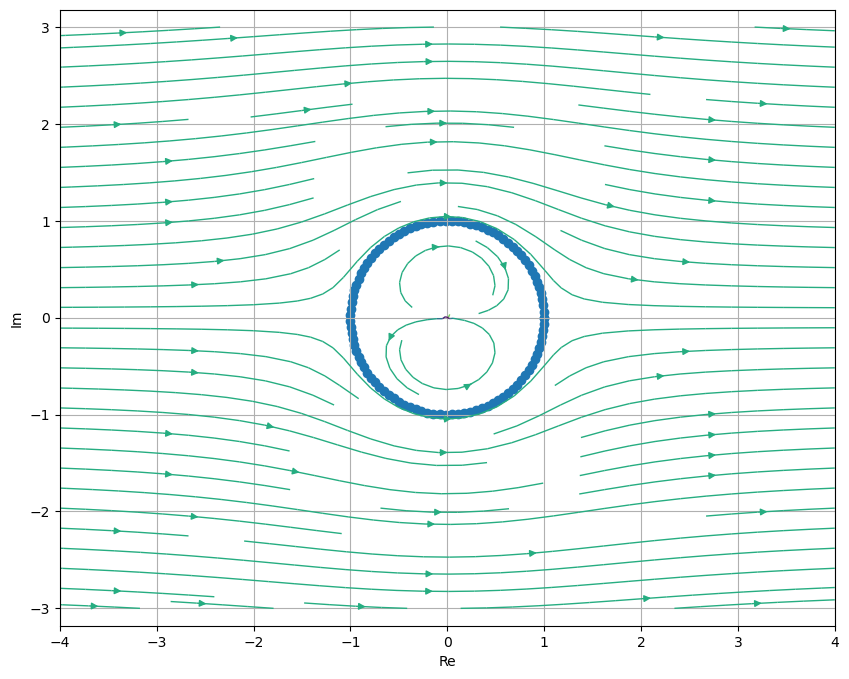

In [1289]:
fig, ax = plt.subplots(1,1,figsize=(10,8))
strm = ax.streamplot(X, Y, U, V, color=U, linewidth=1)
ax.grid(True)

foil_x = complex_to_real(circle_data)[:,0]
foil_y = complex_to_real(circle_data)[:,1]

ax.scatter(foil_x, foil_y)

ax.set_xlabel("Re")
ax.set_ylabel("Im")

ax.axis('equal');

In [1290]:
x = (1-np.cos(np.linspace(0, np.pi, num=300)))/2
new_airfoil_data = np.concatenate(
    (x + 1j* upper_profile(x, *opt_profile_params), 
     x + 1j* lower_profile(x, *opt_profile_params))
)
new_airfoil_data_center = np.average(new_airfoil_data)
new_airfoil_data -= new_airfoil_data_center
new_airfoil_translation = -np.real(new_airfoil_data_center), -np.imag(new_airfoil_data_center)

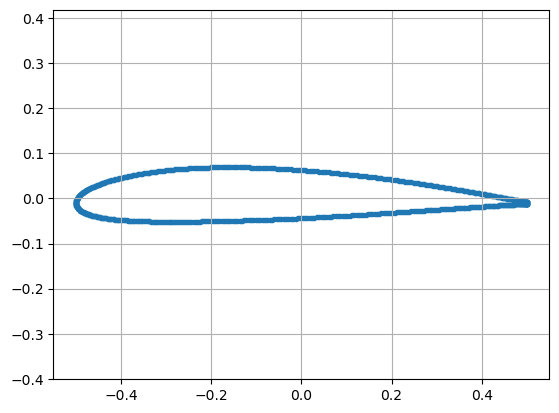

In [1291]:
plt.scatter(
    complex_to_real(new_airfoil_data)[:, 0],
    complex_to_real(new_airfoil_data)[:, 1],
    marker='.'
)
plt.axis('equal')
plt.grid(True)

In [1382]:
%%time 

vx = 1.0
vy = 0.0

foil_potential = FoilComplexPotential(
    lambda x: foil_camber(x, opt_profile_params[0], opt_profile_params[1]),
    new_airfoil_translation,
    0, 10, 20
)
res = foil_potential.fit_translation(vx, vy, new_airfoil_data)
res

Optimization terminated successfully.
         Current function value: 0.000002
         Iterations: 342
         Function evaluations: 38406
         Gradient evaluations: 346
CPU times: user 55.7 s, sys: 5.96 ms, total: 55.7 s
Wall time: 55.7 s


  message: Optimization terminated successfully.
  success: True
   status: 0
      fun: 1.8845331747002245e-06
        x: [ 2.583e-02 -4.651e-01 ...  4.569e-01 -7.339e-03]
      nit: 342
      jac: [-1.551e-07 -3.600e-07 ...  1.829e-07  9.752e-08]
 hess_inv: [[ 2.392e+01  1.795e+01 ...  3.032e+00 -4.008e-01]
            [ 1.795e+01  1.081e+02 ... -1.300e+02  7.304e+00]
            ...
            [ 3.032e+00 -1.300e+02 ...  5.621e+02 -2.799e+01]
            [-4.008e-01  7.304e+00 ... -2.799e+01  1.619e+01]]
     nfev: 38406
     njev: 346

In [1383]:
foil_potential.print_info(res.x)

Количество источников:  0
Координаты источников:  []
Обильности источников:  []
Суммарная обильности источников:  0.0

Количество вихрей:  10
Координаты вихрей:  [[-0.46513553 -0.01371453]
 [-0.33457088  0.00626669]
 [-0.26849626  0.00816252]
 [-0.20296588  0.0095632 ]
 [-0.13365871  0.01066152]
 [-0.06650488  0.01098036]
 [ 0.00105152  0.01026169]
 [ 0.06622748  0.00756927]
 [ 0.15549094  0.00966833]
 [ 0.75835925  0.00878825]]
Обильности вихрей:  [ 0.02582693 -0.00425988 -0.00745747 -0.00368892 -0.00805836 -0.00639606
  0.00830195 -0.01519338 -0.01131283  0.05654196]
Суммарная обильности вихрей:  0.03430393987726506

Количество диполей:  20
Координаты диполей:  [[-4.83481489e-01 -9.03210443e-03]
 [-4.62257240e-01 -4.12068579e-03]
 [-4.25092346e-01 -3.48274261e-03]
 [-3.71617968e-01  1.85129731e-04]
 [-3.10873676e-01  4.08325395e-03]
 [-2.51575634e-01  6.08012187e-03]
 [-2.10745962e-01  2.40103643e-02]
 [-1.88215251e-01  5.78294624e-03]
 [-1.47485497e-01  1.26029802e-02]
 [-1.06621156

In [1384]:
# w, h = 0.75, 0.25
w, h = 3, 1
# w, h = 0.25, 0.08
Y, X = np.mgrid[-h:h:300j, -w:w:300j]
Z = X + 1j*Y
v = foil_potential.velocity(Z, res.x) + vx + 1j*vy
U = np.real(v)
V = np.imag(v)
# psi = np.log10(np.abs(np.imag(foil_potential.velocity(Z, res.x) + (vx - 1j*vy)*Z)))

source_coords, vortex_coords, dipole_coords = foil_potential.get_coords(res.x)

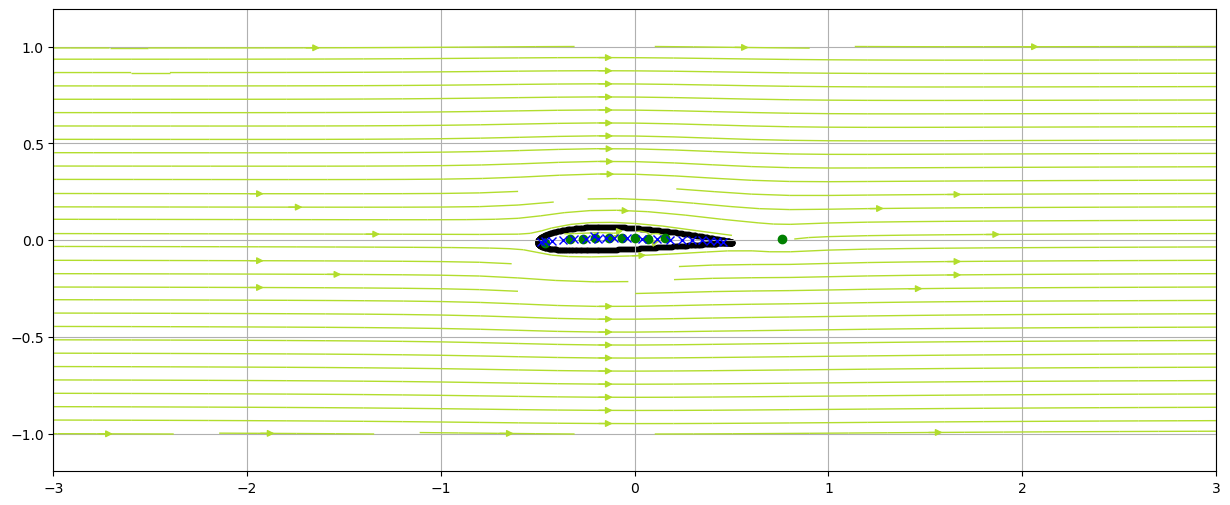

In [1385]:
fig, ax = plt.subplots(nrows=1, figsize=(15,6))

ax.streamplot(X, Y, U, V, color=V, linewidth=1)

foil_x = complex_to_real(new_airfoil_data)[:,0]
foil_y = complex_to_real(new_airfoil_data)[:,1]

ax.scatter(foil_x, foil_y, marker='.', c='k')

for (x, y) in zip(source_coords[0], source_coords[1]):
    plt.plot(x, y, 'r.')

for (x, y) in zip(vortex_coords[0], vortex_coords[1]):
    plt.plot(x, y, 'go')

for (x, y) in zip(dipole_coords[0], dipole_coords[1]):
    plt.plot(x, y, 'bx')

# ax[1].contour(X, Y, psi, levels=40)
# ax[1].scatter(foil_x, foil_y, marker='.', c='k')

# ax.set_xlabel("Re")
# ax.set_ylabel("Im")
# for a in ax:
# ax.set_xlim(-w, w)
ax.axis('equal')
ax.grid(True)